# CS413 Image and Video Analysis -- Coursework

# Sam Moon - 2001779

# Part 1: Resistance is Futile

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import measure
import cv2
import scipy.ndimage as morpho
import matplotlib.patches as patches

from google.colab import drive
drive.mount('/content/drive')

data_dir = 'drive/My Drive/Colab Notebooks/data/courseworkdata/data/RESISTORS/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


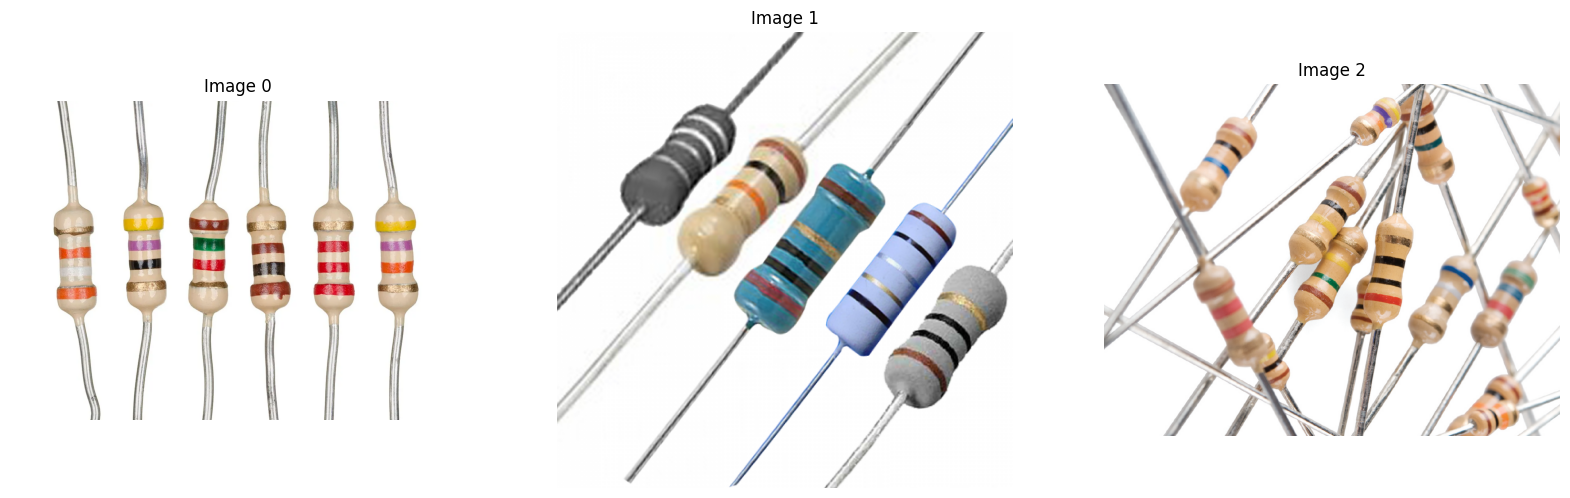

In [108]:
def showImages (ims, cmap = None):
  fig = plt.figure(figsize=(20, 20))

  for i in range(len(ims)):
    plt.subplot(1, len(ims), i+1)
    plt.axis('off')
    plt.title("Image " + str(i))
    plt.imshow(ims[i], cmap)

  plt.show()

res_im = [plt.imread(data_dir + 'RESISTORS-1.png')[:,:,:3], plt.imread(data_dir + 'RESISTORS-2.png')[:,:,:3], plt.imread(data_dir + 'RESISTORS-3.png')[:,:,:3]]
showImages(res_im)

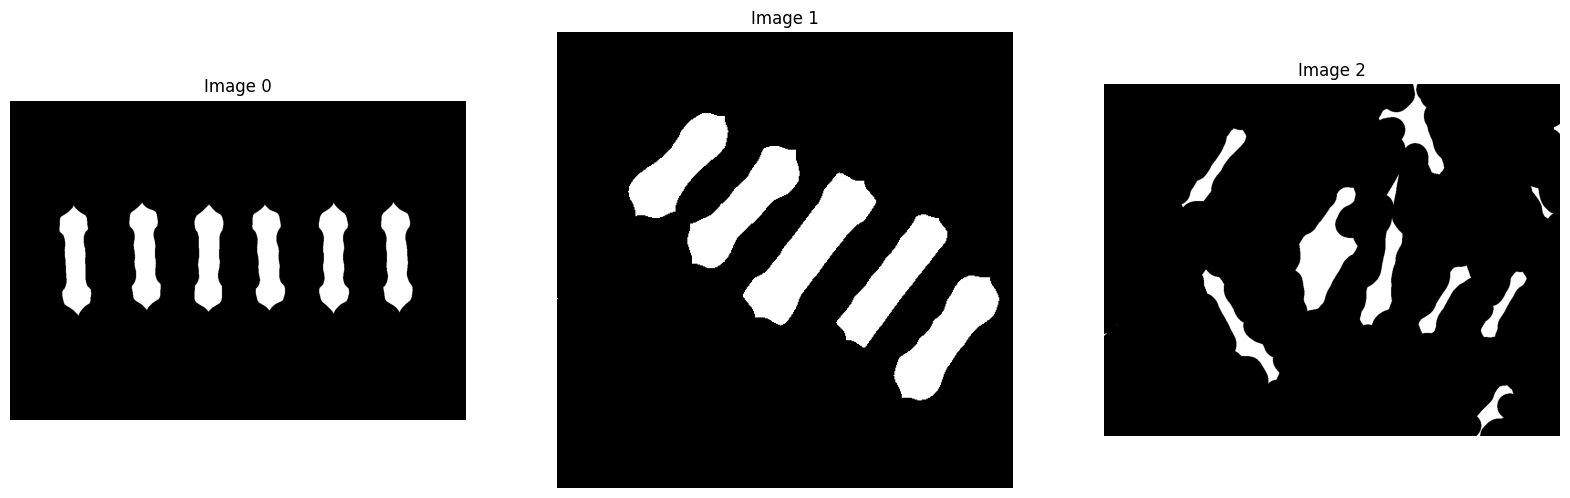

In [109]:
def fg(im, lumThresh, kernelSize, edtThresh):
  fg = np.zeros((im.shape[0], im.shape[1]))

  im = cv2.GaussianBlur(im, (kernelSize, kernelSize), 0)

  fg[0.2126 * im[:,:,0] + 0.7152 * im[:,:,1] + 0.0722 * im[:,:,2] < lumThresh] = 1

  edt = morpho.distance_transform_edt(fg)
  fg[edt < np.max(edt) * edtThresh] = 0

  return fg

res_im_fg = []
for im in res_im:
  res_im_fg.append(fg(im, 0.95, 23, 0.35))

showImages(res_im_fg, cmap = 'gray')

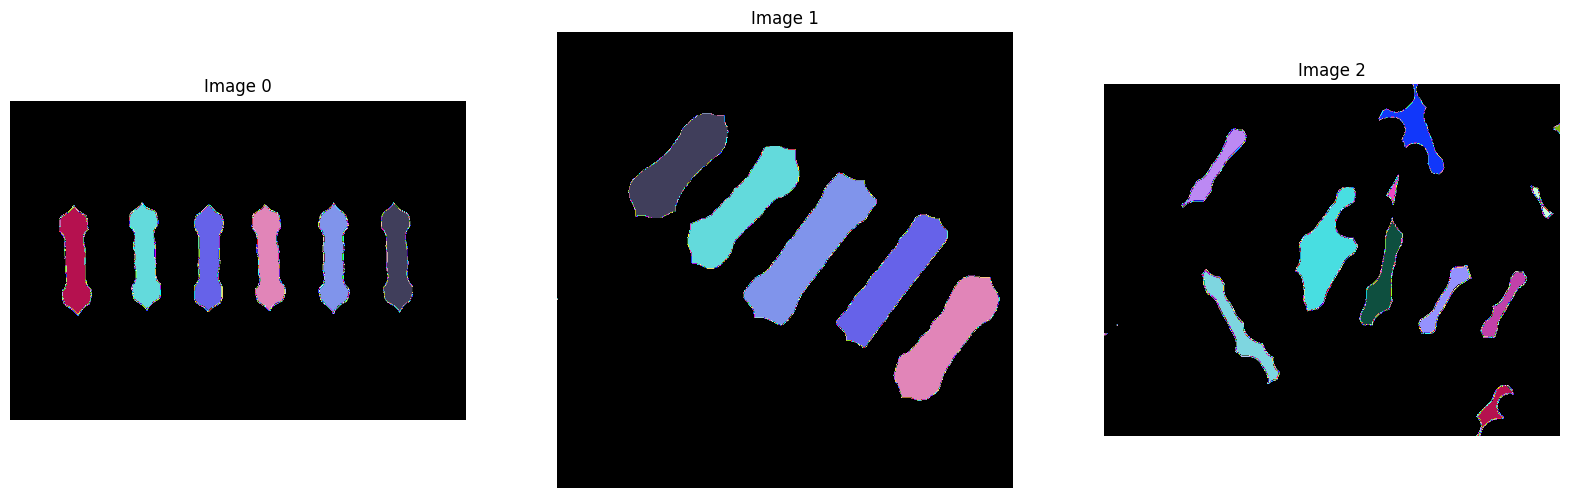

In [110]:
comps = []
for im in res_im_fg:
  comps.append(measure.label(im, background = 0))

rand_colors = np.random.rand(256,3)
rand_colors[0,:] = 0.0
rand_cmap = mpl.colors.ListedColormap(rand_colors)

showImages(comps, rand_cmap)

In [111]:
def boundingBox (comps, label=1):
  xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

  where_x = xx[comps==label]
  where_y = yy[comps==label]

  return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)

def centroid(im):
    xx, yy = np.meshgrid(np.arange(0,im.shape[1]), np.arange(0,im.shape[0]))

    x = xx[im!=0]
    y = yy[im!=0]

    return np.array([np.mean(x),np.mean(y)])

def principal_axis(im):
    m = centroid(im)

    xx, yy = np.meshgrid(np.arange(0,im.shape[1]), np.arange(0,im.shape[0]))

    x = xx[im!=0] - m[0]
    y = yy[im!=0] - m[1]

    xy = np.vstack((x, y))

    xy2 = np.matmul(xy, np.transpose(xy))

    eval, evec = np.linalg.eig(xy2)
    p_axes = np.identity(2)
    if (eval[0]>eval[1]):
        p_axes = evec[0,:]
    else:
        p_axes = evec[1,:]

    p_axes /= np.linalg.norm(p_axes)

    return p_axes

def ED(c1, c2):
  c1 = c1.astype('int32')
  c2 = c2.astype('int32')
  return np.sqrt(np.square(c1[0] - c2[0]) + np.square(c1[1] - c2[1]) + np.square(c1[2] - c2[2]))

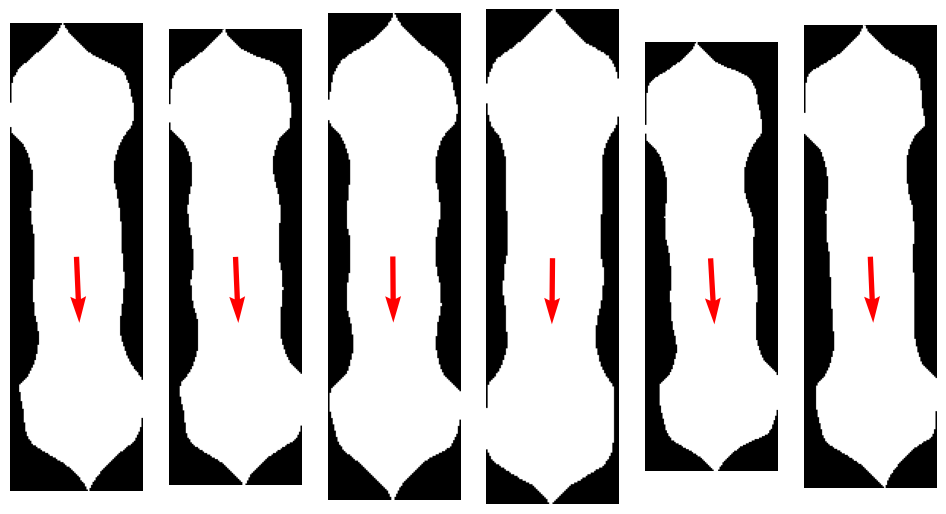

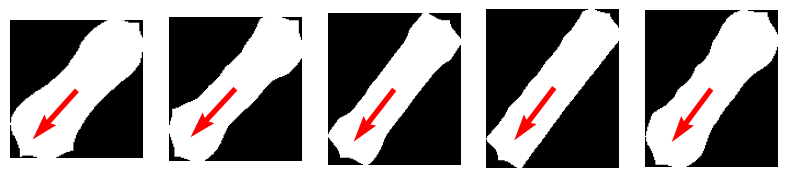

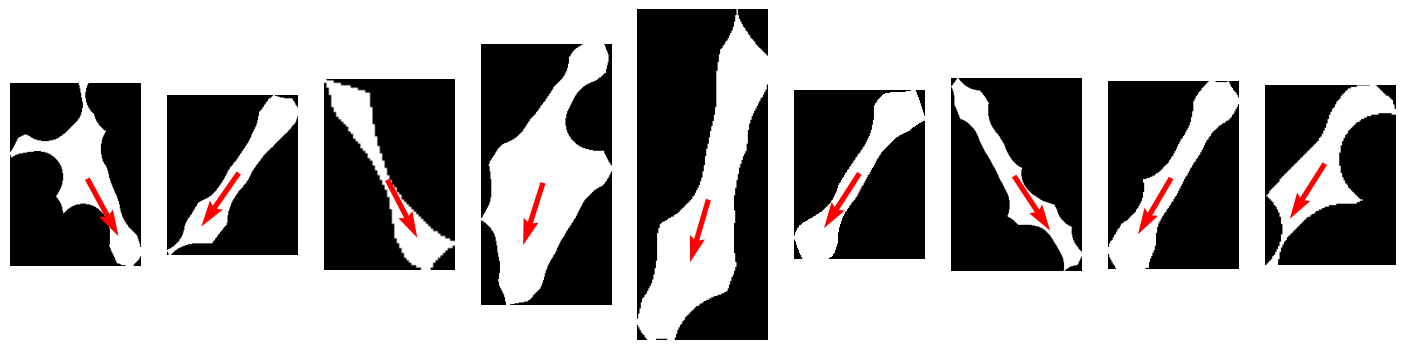

In [112]:
bounds = []
centroids = []
angles = []
components = []

for i in range(len(comps)):
  comp = comps[i]

  unique = np.unique(comp)

  min_size = np.min(res_im[i].shape[:2]) * 0.05
  max_size = np.max(res_im[i].shape[:2]) * 0.75

  bounding_boxes = []
  component_images = []
  axis_angles = []
  component_centroids = []

  fig = plt.figure(figsize=(2*len(unique), 2*len(unique)))
  j = 1

  for l in unique:
      bb = boundingBox(comp, label=l)

      one_comp = np.zeros(comp.shape, dtype='uint8')
      one_comp[comp==l] = 1

      one_comp = one_comp[bb[1]:bb[3],bb[0]:bb[2]]

      if (one_comp.shape[0] > min_size and one_comp.shape[1] > min_size and one_comp.shape[0] < max_size and one_comp.shape[1] < max_size):
        bounding_boxes.append(bb)
        component_images.append(one_comp)

        pos = centroid(one_comp)
        component_centroids.append(pos)

        axis = principal_axis(one_comp)

        theta = np.degrees(np.arctan(axis[0] / axis[1]))
        axis_angles.append(theta)

        plt.subplot(1, len(unique), j)
        plt.imshow(one_comp, cmap='gray')
        plt.axis('off')
        plt.quiver(pos[0], pos[1], axis[0], axis[1], scale=2, width=0.04, color=(1,0,0))

        j+=1

  bounds.append(bounding_boxes)
  components.append(component_images)
  angles.append(axis_angles)
  centroids.append(component_centroids)
  plt.show()

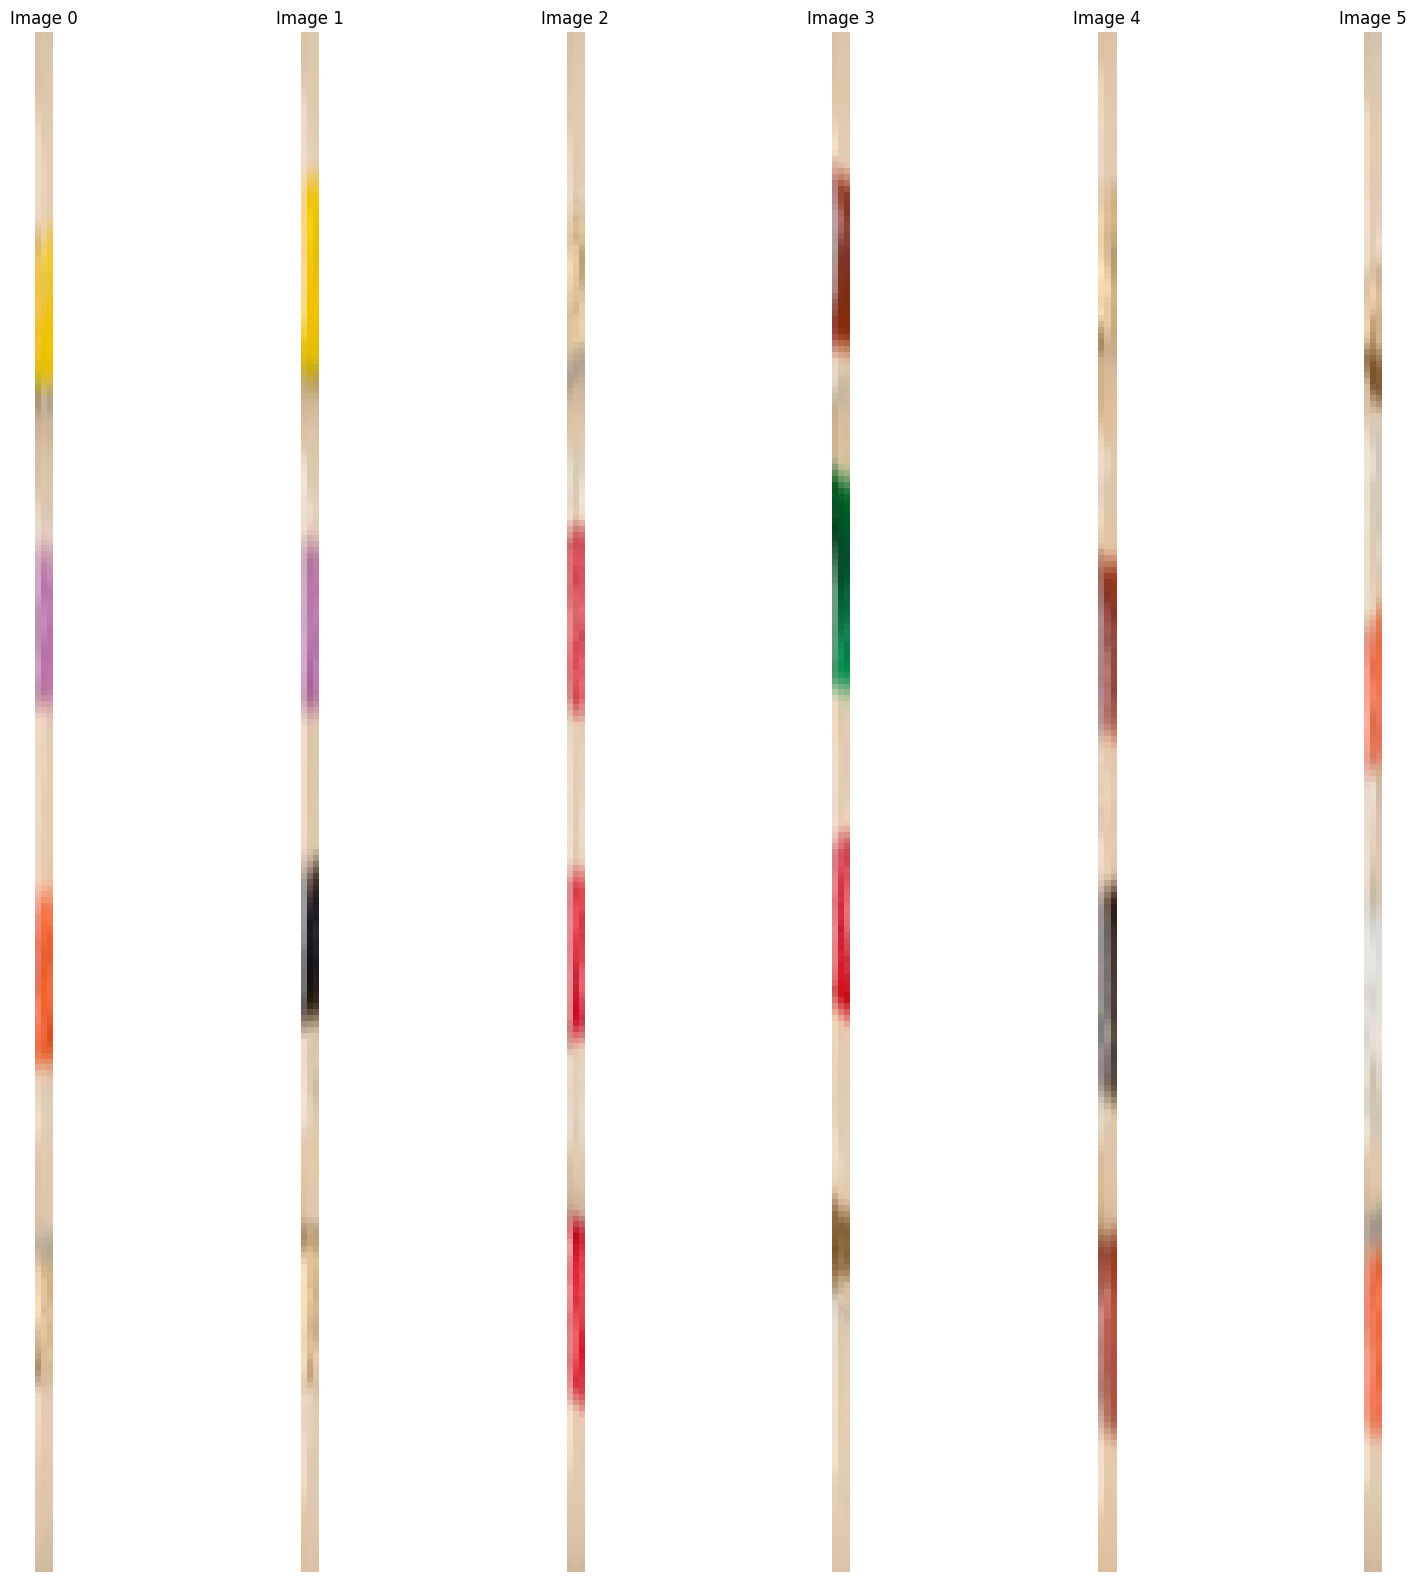

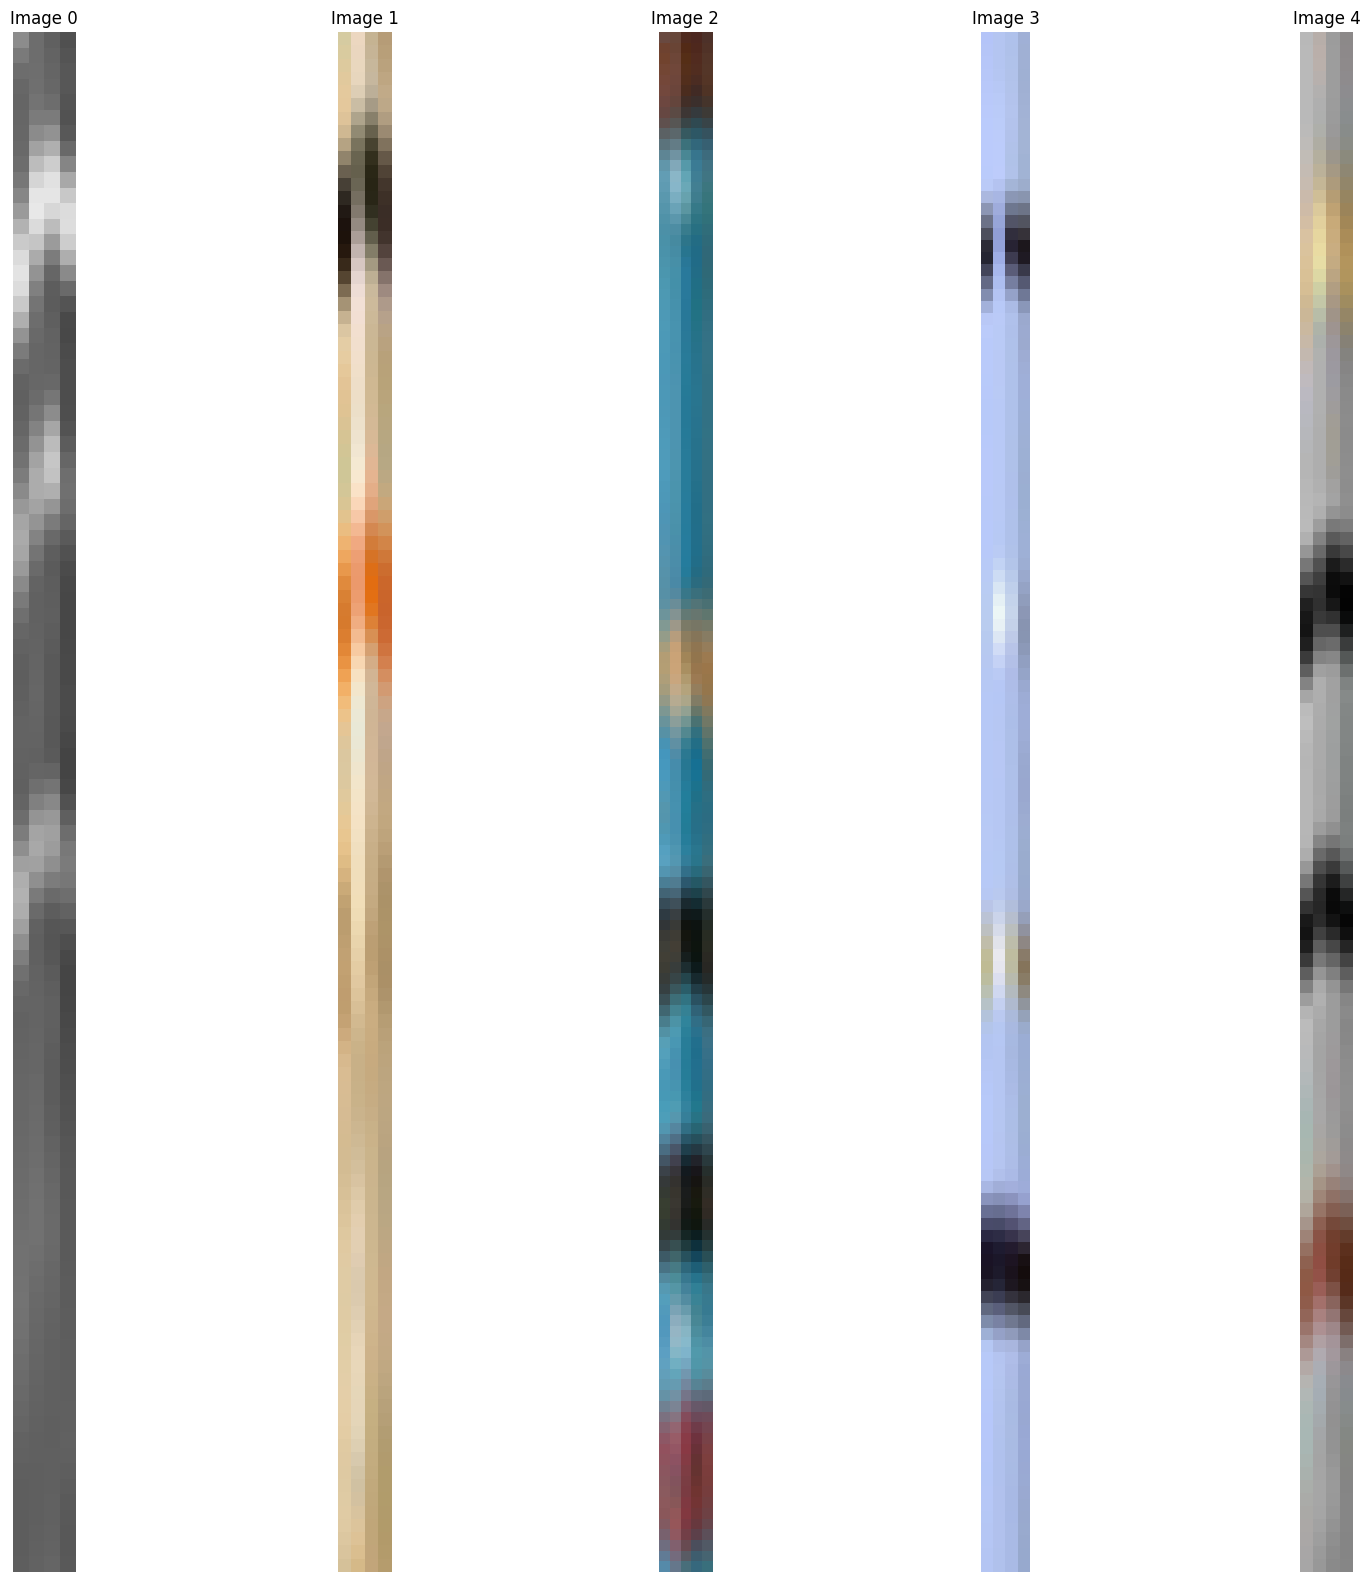

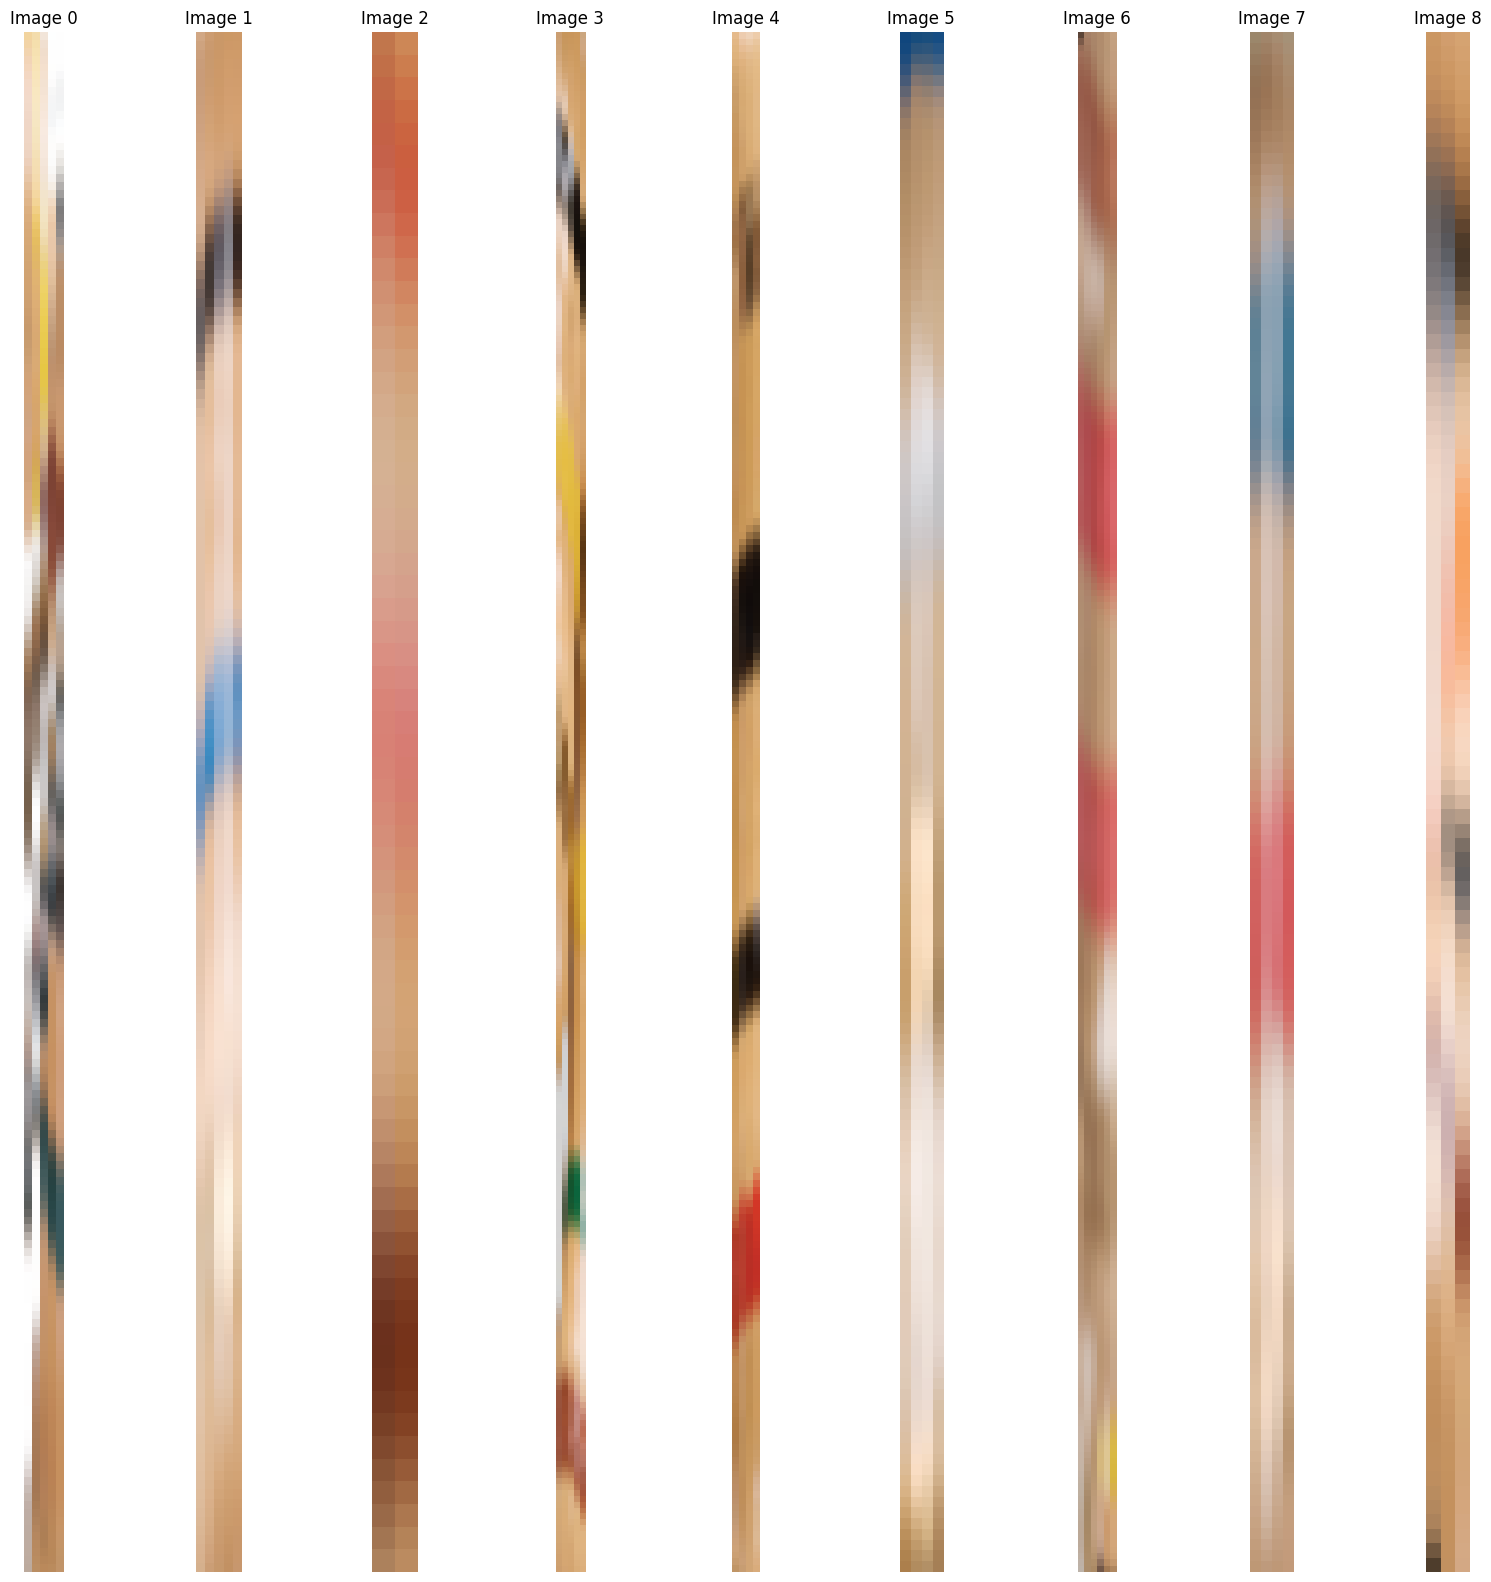

In [113]:
resistors = []
edges = []
for i in range(len(res_im)):
  res = []
  for j in range(len(bounds[i])):
    resistor = np.copy(res_im[i][bounds[i][j][1]:bounds[i][j][3], bounds[i][j][0]:bounds[i][j][2]])

    rotation = cv2.getRotationMatrix2D(centroids[i][j], angles[i][j], 1)
    resistor = cv2.warpAffine(resistor, rotation, (resistor.shape[1], resistor.shape[0]), flags=cv2.INTER_LINEAR)

    resistor = cv2.blur(resistor, (1, 5))
    resistor = resistor[resistor.shape[0]//15:-resistor.shape[0]//15, resistor.shape[1]//3:-resistor.shape[1]//3]

    resistor = cv2.resize(resistor, (0,0), fx=0.1, fy=1, interpolation=cv2.INTER_NEAREST)

    res.append(resistor)

  showImages(res)
  resistors.append(res)

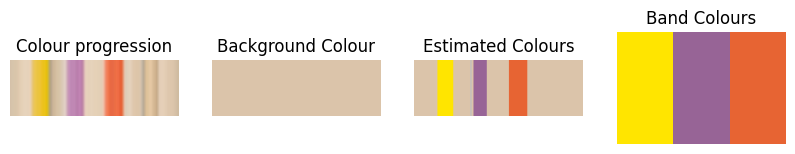

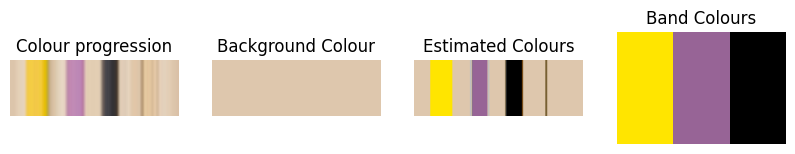

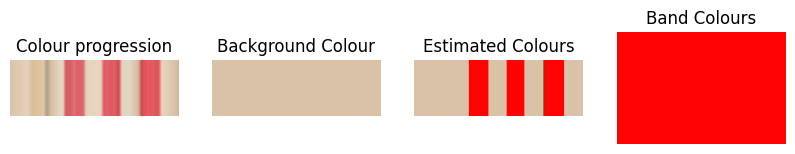

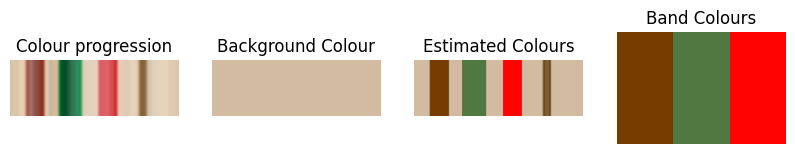

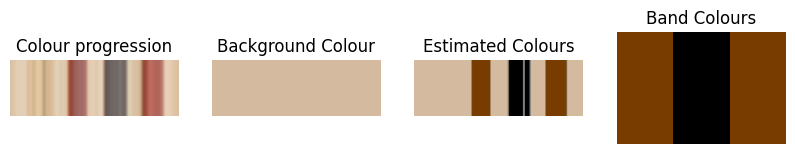

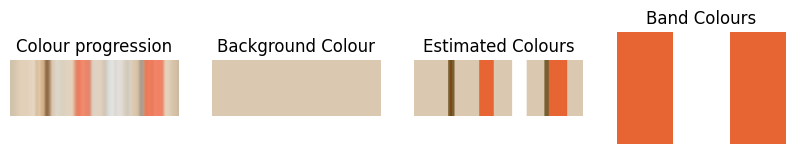

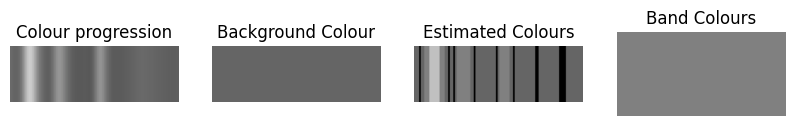

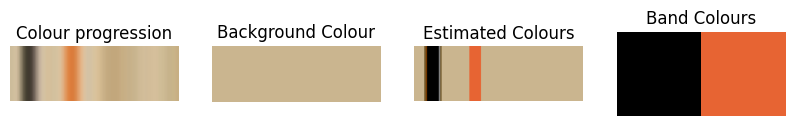

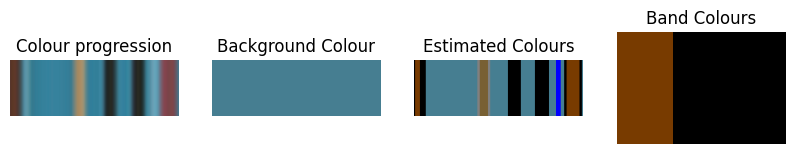

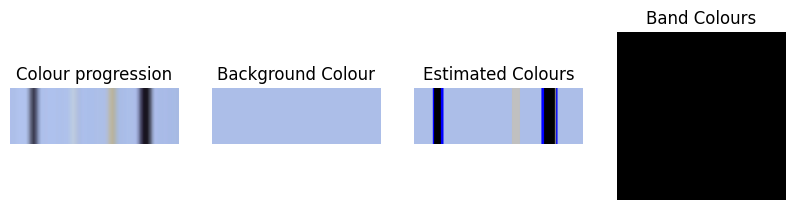

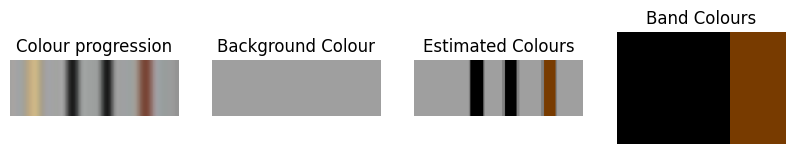

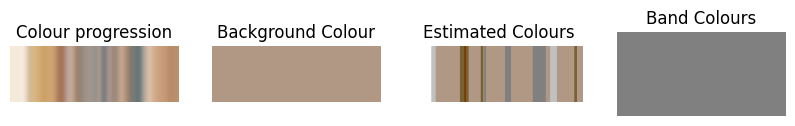

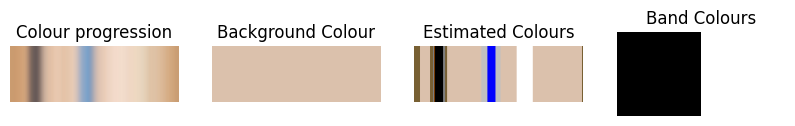

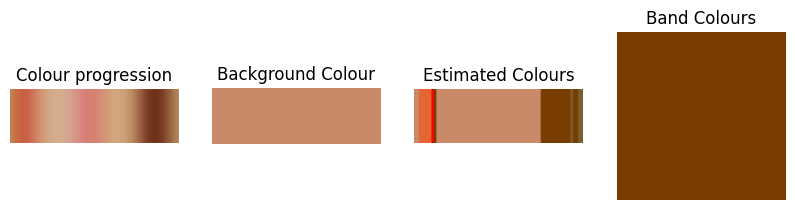

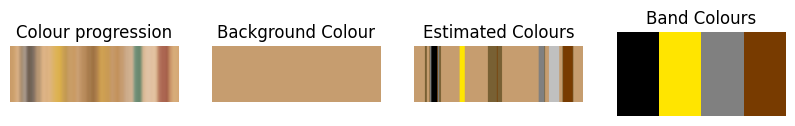

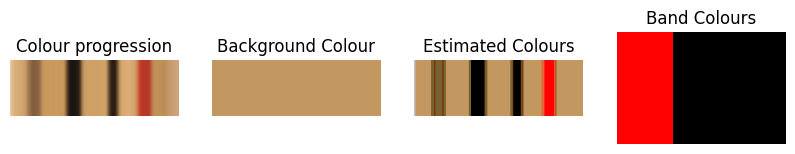

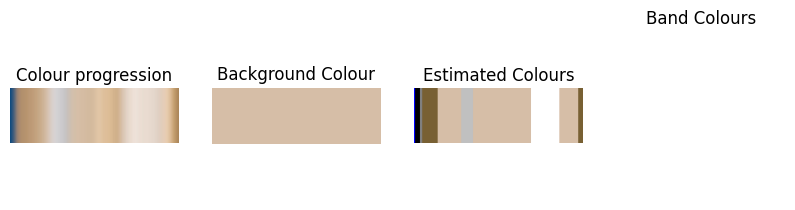

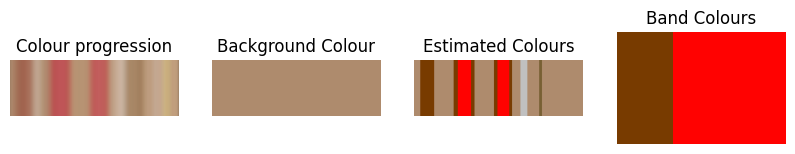

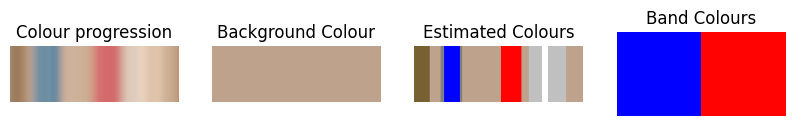

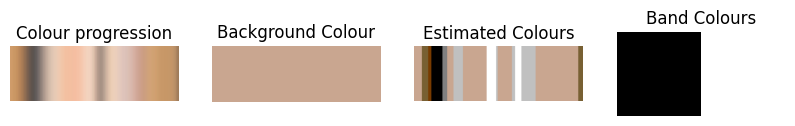

In [114]:
band_colours_RGB = [
    [[0, 0, 0], [25, 25, 25], [50, 50, 50], [75, 75, 75], [100, 100, 100]], #blacks
    [[120, 60, 0], [110, 40, 15], [130, 70, 60], [150, 100, 90], [165, 80, 70], [185, 105, 90]], #browns
    [[255, 0, 0], [170, 75, 70], [135, 10, 10], [210, 40, 40], [128, 0, 0], [180, 65, 75], [200, 100, 100]], #reds
    [[230, 100, 50], [255, 165, 0], [255, 170, 30], [255, 130, 80], [200, 90, 50]], #oranges
    [[255, 230, 0], [255, 220, 10], [255, 255, 50], [255, 255, 0], [230, 185, 40]], #yellows
    [[80, 120, 65], [0, 255, 0], [170, 255, 0], [80, 200, 120], [35, 140, 35], [0, 128, 0], [50, 205, 50], [15, 255, 80], [0, 160, 100], [10, 70, 40]], #greens
    [[0, 0, 255], [0, 255, 255], [140, 210, 240], [0, 150, 255], [0, 70, 170], [0, 0, 140], [20, 50, 165], [60, 0, 255], [0, 0, 128], [30, 80, 255], [15, 80, 185], [5, 55, 175], [95, 140, 190]], #blues
    [[150, 100, 150], [190, 65, 190], [110, 40, 100], [95, 65, 210], [220, 110, 215], [125, 0, 255]], #purples
    [[128, 128, 128]], #greys
    [[255, 255, 255], [230, 230, 230]], #whites
    [[192, 192, 192]], #silver
    [[120, 95, 50], [166, 137, 97]] #gold
                  ]

band_colours = []
for cs_RGB in band_colours_RGB:
  cs = []
  for c in cs_RGB:
    cs.append(cv2.cvtColor(np.uint8([[c]]), cv2.COLOR_RGB2LAB)[0][0])
  band_colours.append(cs)

res_bands = []

for im in range(len(resistors)):
  im_bands = []
  for i in range(len(resistors[im])):
    res_lab = cv2.cvtColor((255 * resistors[im][i]).astype('uint8'), cv2.COLOR_RGB2LAB)
    mean = np.mean(res_lab, axis = 1).astype('uint8')

    mean_reduced = []

    bg = np.median(mean, axis = 0).astype('uint8')

    for j in range(mean.shape[0]):
      min_distance = ED(mean[j], bg) * 0.75
      min_colour = bg
      for cs in band_colours:
        for c in cs:
          d = ED(mean[j], c)
          if d < min_distance:
            min_distance = d
            min_colour = cs[0]
      mean_reduced.append(min_colour)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(np.resize(mean, (len(mean)//3, len(mean), 3)), cv2.COLOR_LAB2RGB))
    plt.axis('off')
    plt.title('Colour progression')

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(np.resize(bg, (1, 3, 3)), cv2.COLOR_LAB2RGB))
    plt.axis('off')
    plt.title('Background Colour')

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(np.resize(np.uint8(mean_reduced), (len(mean_reduced)//3, len(mean_reduced), 3)), cv2.COLOR_LAB2RGB))
    plt.axis('off')
    plt.title('Estimated Colours')

    bands = []
    count = 1
    min_band_size = 5
    band = False
    for j in range(1, len(mean_reduced)):
      if np.all(mean_reduced[j] == mean_reduced[j-1]):
        count+=1
      elif count > min_band_size and np.any(mean_reduced[j-1] != bg):
        if band:
          bands.append(mean_reduced[j-1])
          min_band_size = np.max([min_band_size, count // 3])
          band = False
        count = 1
      else:
        count = 1
        band = True

    if np.all(bands[0] == band_colours[10][0]) or np.all(bands[0] == band_colours[11][0]):
      bands.reverse()

    l = len(bands)
    i = 0
    while i < l:
      if np.all(bands[i] == band_colours[10][0]) or np.all(bands[i] == band_colours[11][0]):
        bands.pop(i)
        l-=1
      else:
        i+=1

    plt.subplot(1, 4, 4)
    plt.title('Band Colours')
    plt.imshow(cv2.cvtColor(np.resize(np.array(bands), (1 + len(bands)//3, len(bands), 3)), cv2.COLOR_LAB2RGB))
    plt.axis('off')

    plt.show()

    im_bands.append(bands)
  res_bands.append(im_bands)

In [115]:
res_resistance = []
for im in res_bands:
  im_resistance = []
  for band in im:
    resistance = 0
    for i in range(len(band)):
      for j in range(len(band_colours)):
        if j < 0 or j > 9:
          continue
        if np.all(band[i] == band_colours[j][0]):
          if i == len(band) - 1:
            resistance *= 10**j
          else:
            resistance += (10**((len(band)-2)-i))*j
          continue
    im_resistance.append(resistance)
  res_resistance.append(im_resistance)

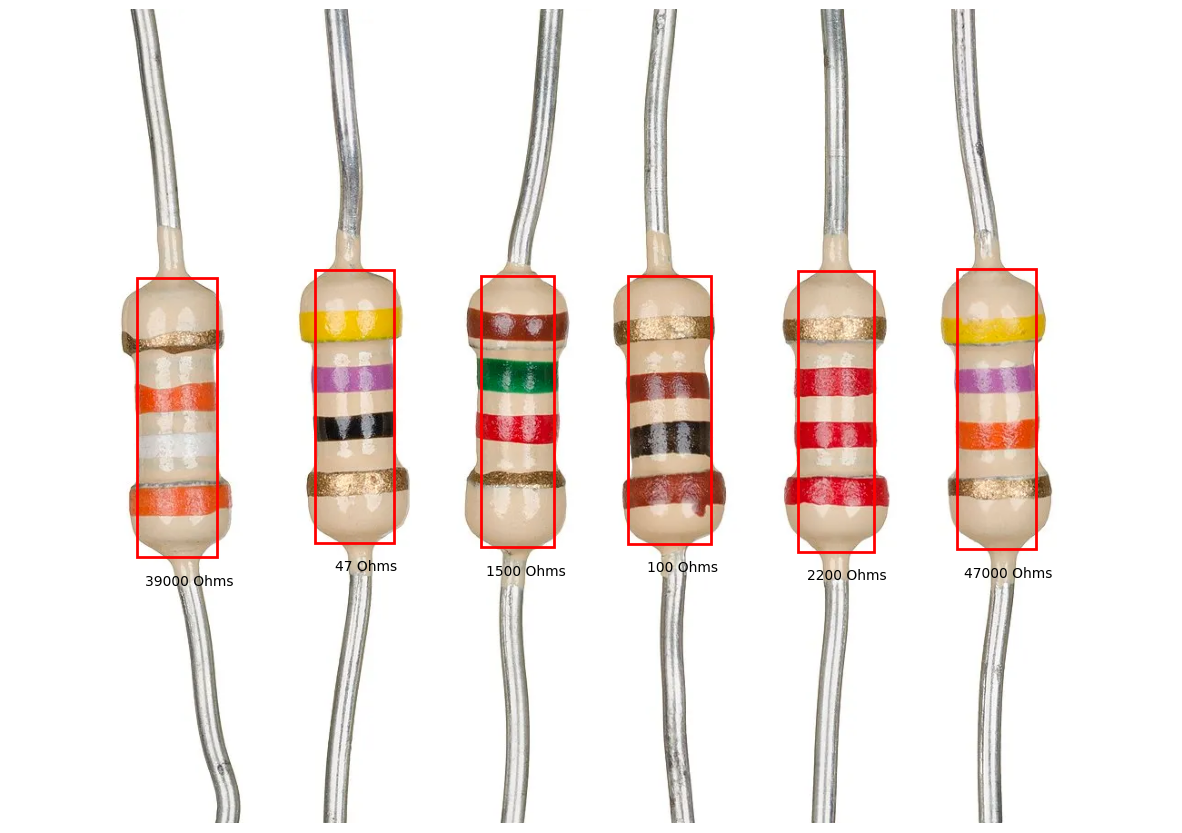

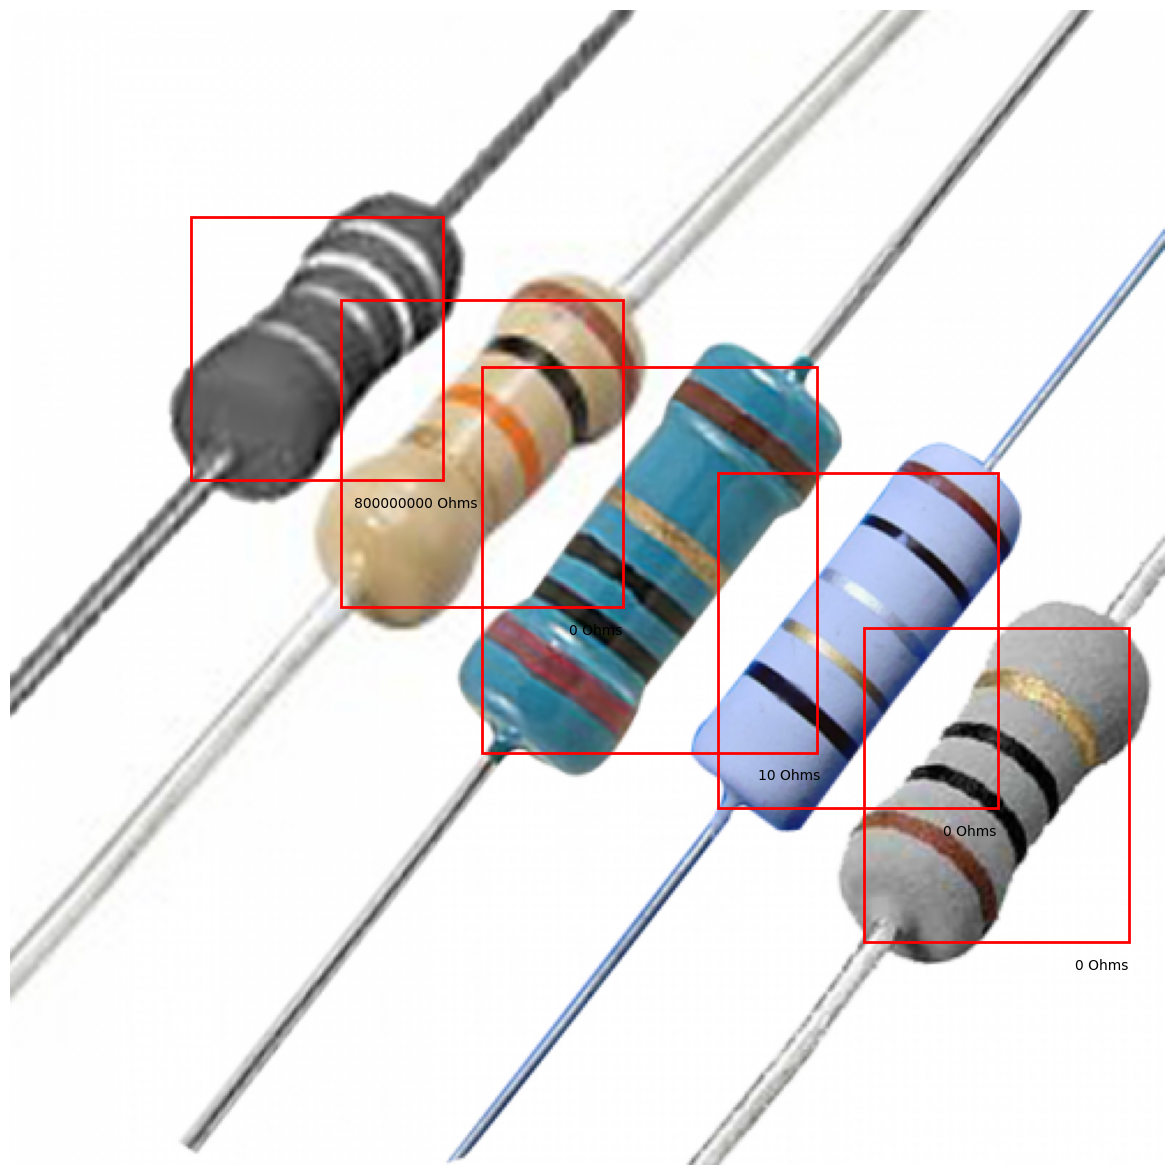

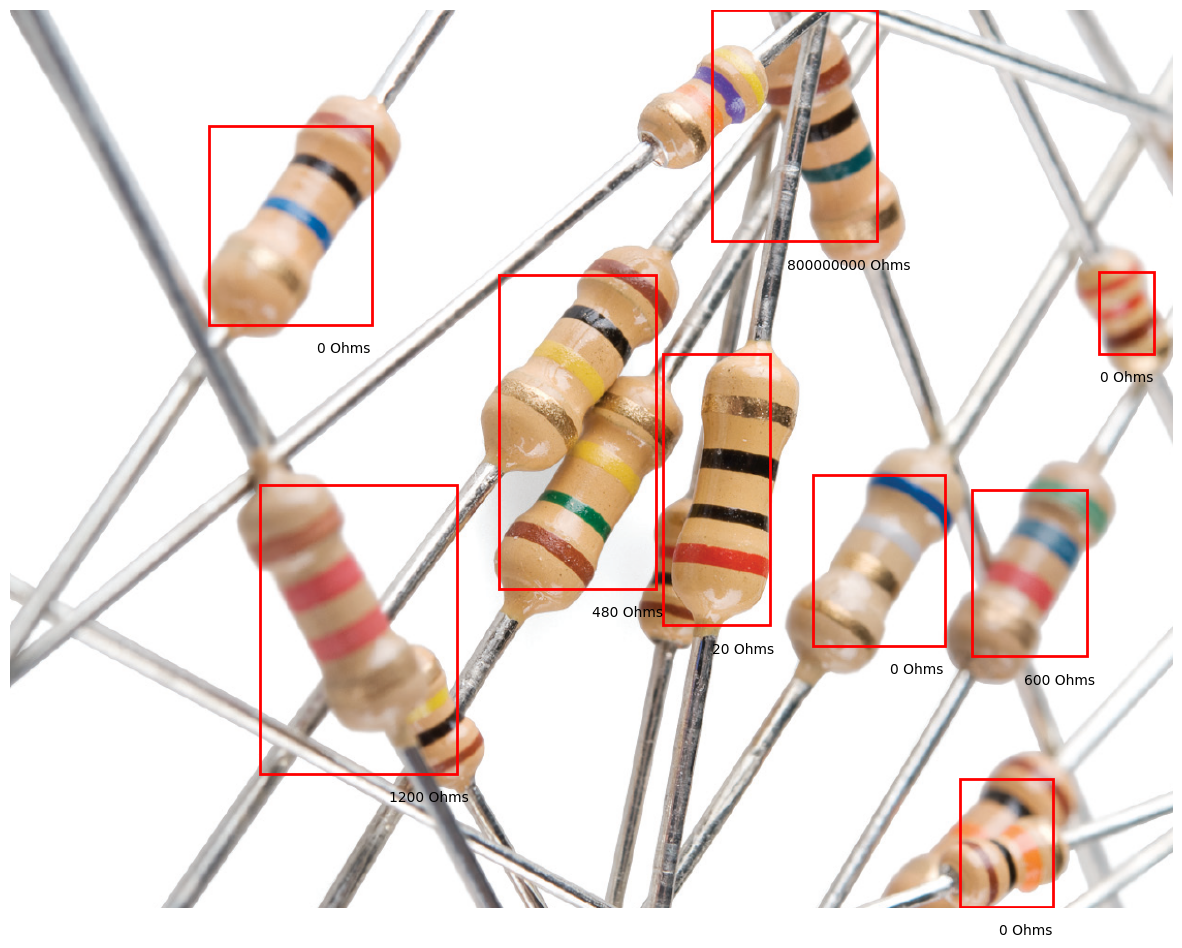

In [116]:
for i in range(len(res_resistance)):
  fig = plt.figure(figsize=(15, 15))
  ax = fig.add_subplot(111)

  plt.axis('off')
  plt.imshow(res_im[i])
  for j in range(len(res_resistance[i])):
    ax.add_patch(patches.Rectangle((bounds[i][j][2], bounds[i][j][3]), bounds[i][j][0] - bounds[i][j][2], bounds[i][j][1] - bounds[i][j][3], linewidth = 2, edgecolor='r', fill = False))
    plt.annotate(str(res_resistance[i][j]) + " Ohms",
                 (bounds[i][j][2], bounds[i][j][3]),
                 textcoords="offset points",
                 xytext=(-20,-20),
                 ha='center',
                 color=(0,0,0))

  plt.show()